# Assignment 6
#### Problem 2

Jérémie Engler and Laure Toullier

07.12.2023

Aim : analysis of a cantilever beam-column element subjected to a tip force

In [1]:
#imports

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import math

np.set_printoptions(precision=5, suppress=True, linewidth=150)

Params = plt.rcParams
Params['figure.figsize'] = (14, 7) 

In [2]:
#Data

a = 200 #mm
b = 200 #mm
L = 2000 #mm (uniform XS)
E = 200000 #MPa (elastic material)
nf = 10 #number of fibers in the XS
stress_fibers = np.ones(nf) #initial stress in each fiber

Step 1 : Implement and validate a displacement based fiber beam-column element

In [3]:
#computation of tangent section stiffness matrix and section resisting force

def ks_fs(nf, stress_fibers):

    yk=np.zeros((nf))    #array for each the coordinate of each centroïd of each fiber
    lk=np.zeros((nf,2))
    ks=np.zeros((2,2))   #tangent section stiffness matrix
    fs=np.zeros((2,1))   #section resisting force

    for i in range(nf):
        yk[i]=-b/2+b/(2*nf)+b/nf*((i+1)-1) #centroïd of each fiber
        lki=np.array([[1,yk[i]]])
        lk[i]=lki
        ks+=np.transpose(lki)@lki*E*(a*b/nf)
        fs+=np.transpose(lki)*stress_fibers[i]*(a*b/nf)

    return ks, fs

#note: as the XS is constant, ks and fs are constant along the cantilever

The numerical integration used to obtain a numerical estimate of the integral is Gauss-Lobato, with 5 integration points. The conditions that satisfy all error partial derivatives for 5 integration points are:

    w1=w5=1/10 and r1=1, r5=-1

    w2=w4=49/90 and r2=-sqrt(21)/7, r4=sqrt(21)/7 
    
    w3=32/45 and r3=0

In [5]:
#computation of the stiffness matrix

w=np.array([0.1,49/90,32/45,49/90,0.1])

def Ke_Qe(L,w,k_s,f_s,B):
    
    Ke=np.zeros((6,6))
    Qfv=np.zeros((6,1))

    for i in range(len(w)) :
                
        kb=(B.T@k_s)@B
        Ke+=L/2*w[i]*kb

        qb=B.T@f_s
        Qfv+=L/2*qb*w[i]

    return Ke, Qfv




In [6]:
k_s,f_s=ks_fs(nf, stress_fibers)
B=B_matrix(L,r)
K_e,Q_e=Ke_Qe(L,w,k_s,f_s,B)


In [7]:
print(f"k_s={k_s}")
print(f"f_s={f_s}")
print(f"The element resisting force vector is ")
print(Q_e)
print("The tangent element stiffness matrix of a displacement based fiber BC elemnt is:")
print(K_e)

k_s=[[8.00e+09 0.00e+00]
 [0.00e+00 2.64e+13]]
f_s=[[40000.]
 [    0.]]
The element resisting force vector is 
[[-40000.]
 [     0.]
 [     0.]
 [ 40000.]
 [     0.]
 [     0.]]
The tangent element stiffness matrix of a displacement based fiber BC elemnt is:
[[ 4.000e+06  0.000e+00  0.000e+00 -4.000e+06  0.000e+00  0.000e+00]
 [ 0.000e+00  1.188e+05  1.584e+08  0.000e+00 -1.188e+05  7.920e+07]
 [ 0.000e+00  1.584e+08  2.112e+11  0.000e+00 -1.584e+08  1.056e+11]
 [-4.000e+06  0.000e+00  0.000e+00  4.000e+06  0.000e+00  0.000e+00]
 [ 0.000e+00 -1.188e+05 -1.584e+08  0.000e+00  1.188e+05 -7.920e+07]
 [ 0.000e+00  7.920e+07  1.056e+11  0.000e+00 -7.920e+07  5.280e+10]]


In [8]:
#classical stiffness matrix (from week 7, slide 19)

def stiffness_elastic_beam (E,a,b,L):

    K=np.zeros((6,6))

    I=a*b**3/12
    A=a*b
    
    K[0,0]=E*A/L
    K[0,3]=-E*A/L
    K[3,0]=-E*A/L
    K[3,3]=E*A/L

    K[1,1]=K[4,4]=E*I*12/L**3
    K[1,2]=K[2,1]=E*I*6/L**2
    K[2,2]=K[5,5]=E*I*4/L
    K[5,4]=K[4,5]=-6*E*I/L**2

    K[1,4]=K[4,1]=-E*I*12/L**3
    K[1,5]=K[5,1]=E*I*6/L**2
    K[2,4]=K[4,2]=-E*I*6/L**2
    K[2,5]=K[5,2]=E*I*2/L

    return K

K_classic=stiffness_elastic_beam (E,a,b,L)
print(f"K_classic={K_classic}")


K_classic=[[ 4.00000e+06  0.00000e+00  0.00000e+00 -4.00000e+06  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  4.00000e+04  4.00000e+07  0.00000e+00 -4.00000e+04  4.00000e+07]
 [ 0.00000e+00  4.00000e+07  5.33333e+10  0.00000e+00 -4.00000e+07  2.66667e+10]
 [-4.00000e+06  0.00000e+00  0.00000e+00  4.00000e+06  0.00000e+00  0.00000e+00]
 [ 0.00000e+00 -4.00000e+04 -4.00000e+07  0.00000e+00  4.00000e+04 -4.00000e+07]
 [ 0.00000e+00  4.00000e+07  2.66667e+10  0.00000e+00 -4.00000e+07  5.33333e+10]]


In [9]:
#computation of the error

def error(nf):
    k_s,f_s=ks_fs(nf, stress_fibers)
    K_e,Q=Ke_Qe(L,w,k_s,f_s,B)
    
    err=np.linalg.norm(K_e-K_classic)/np.linalg.norm(K_classic)*100
    return err

def error_min(err_accept):
    n_iter=20
    n=1
    while error(n)>err_accept and n<n_iter:
        n+=1
    return n


In [10]:
err=error(nf)
print(f"error={err}")
min_num_fibers=error_min(2)
err_min=error(min_num_fibers)
print(f"Minimum number of fibers for error less than 2%={min_num_fibers}")
print(f"For a minimum number of fiber less than 2%, the error is: {err_min}")

error=229.28146981139


IndexError: index 10 is out of bounds for axis 0 with size 10

Step 2: Conduct a load control analysis with your beam-column element

Aim: create a cantilever model using displacement-based fiber beam-column element.

In [ ]:
nf=min_num_fibers #8 according to step 1
V_end=450000
q0=np.transpose(np.array([[0,0,0,0,0,0]]))
Q_ext=np.transpose(np.array([[0,0,0,0,V_end,0]]))
num_incr=30          #number of increments
tol=10**(-8)
max_iter=16
iteration_counter=1
stress_fibers=np.zeros((nf)) #new stress in each fiber for new number of fibers

In [ ]:
#newton raphson method

#initialisation
force5=[]
disp5=[]
iteration_counter=[0]
q=q0
k_s, f_s=ks_fs(nf, stress_fibers)
B=B_matrix(L,r)
K_e, Q_e= Ke_Qe(L,w,k_s,f_s,B)
ds=section_deformation(B,q)


for j in range(1, num_incr-1):
    print(f"%%%%%%%%%%%%%%%%%%%%%%%%%%{j}th increment%%%%%%%%%%%%%%%%%%%%%%%%%%")
       
    iteration_counter.append(j+1)

    Q_ext_i=(j+1)/num_incr*Q_ext
    print(f"Q_ext_i={Q_ext_i}")

    k_s, f_s=ks_fs(nf, stress_fibers)
    B=B_matrix(n,L,r)
    K_e, Q_e= Ke_Qe(L,w,k_s,f_s,B)

    R_1=Q_ext_i-Q_e

    for i in range(max_iter):
        print(f"%%%%%%%%%%%%%%%%%%%%%%%%%{i}th iteration%%%%%%%%%%%%%%%%%%%%%%%%%%")

        K_ff=K_e[3:6,3:6] #we only consider the free DOF from Ke
        R_f=R[3:6,:] #we only consider the free DOF from R

        #displacement
        delta_q_f=displacement_incr(K_ff,R_f)
        q=q+delta_q_f
        print(f"q={q}")

        #section deformation
        ds=section_deformation(B,q)

        #stresses in each fiber
        stress_fiber=fiber_stresses(nf,b,ds)

        #Element stiffness and element resisting force vector computed with new stresses in fibers
        k_s, f_s=ks_fs(nf, stress_fibers)
        B, K_e, Q_e= Ke_Qe(L,w,r,k_s,f_s) 
        print(f"Qe={Q_e}")

        R=Q_ext_i-Q_e
        print(f"R={R}")
        norm_R=np.linalg.norm(R)
        norm_Qext=np.linalg.norm(Q_ext_i)

        if norm_R/norm_Qext<tol or i>max_iter:
            force5.append(Q_e[4][0])
            disp5.append(q[4][0])
            break #if the tolerance is reached, we need to go "out of the loop" to go to the newt load iteration

        if norm_R/norm_Qext>tol and i==max_iter-1:
            #print("no convergence")
            raise ValueError("No convergence !")
        
        else:
            i+=1

    #return q, Q_e, force, disp
    

%%%%%%%%%%%%%%%%%%%%%%%%%%0th increment%%%%%%%%%%%%%%%%%%%%%%%%%%
Q_ext_i=[[    0.]
 [    0.]
 [    0.]
 [    0.]
 [15000.]
 [    0.]]
%%%%%%%%%%%%%%%%%%%%%%%%%0th iteration%%%%%%%%%%%%%%%%%%%%%%%%%%
delta_q_f=[[0.     ]
 [1.52381]
 [0.00114]]
q=[[0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [1.52381]
 [0.00114]]
yk=[-87.5 -62.5 -37.5 -12.5  12.5  37.5  62.5  87.5]
strain in fibers=[ 0.  0.  0.  0. -0. -0. -0. -0.]
stress in fibers=[ 0.  0.  0.  0. -0. -0. -0. -0.]
Qe=[[-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [-0.]]
R=[[    0.]
 [   -0.]
 [   -0.]
 [   -0.]
 [15000.]
 [    0.]]
%%%%%%%%%%%%%%%%%%%%%%%%%1th iteration%%%%%%%%%%%%%%%%%%%%%%%%%%
delta_q_f=[[0.     ]
 [1.52381]
 [0.00114]]
q=[[0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [3.04762]
 [0.00229]]
yk=[-87.5 -62.5 -37.5 -12.5  12.5  37.5  62.5  87.5]
strain in fibers=[ 0.  0.  0.  0. -0. -0. -0. -0.]
stress in fibers=[ 0.  0.  0.  0. -0. -0. -0. -0.]
Qe=[[-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [-0.]]
R=[[    0.]
 [   -0.]
 [   -0.]
 [   -0.]
 [

ValueError: No convergence !

In [ ]:

def printgraph(x,y,xname,yname,unit1, unit2):
    plt.figure(figsize=(7, 5))
    plt.plot(x,y,'o')
    plt.plot(x,y,'b')
    
    # Show a straight line
    plt.axline((x[0], y[0]), (x[1], y[1]))

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")

    plt.show()

    return None

ValueError: x and y must have same first dimension, but have shapes (2,) and (0,)

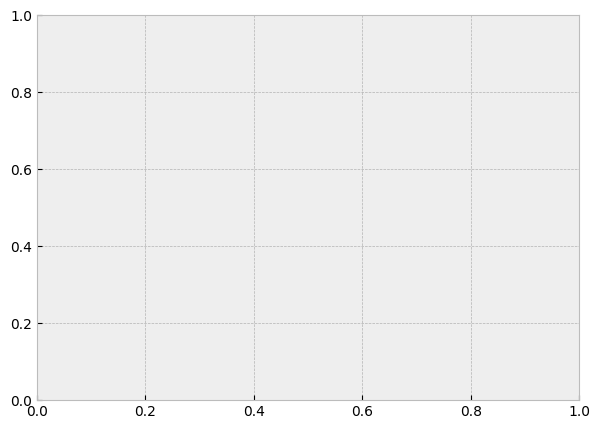

In [ ]:
printgraph(iteration_counter,force5,"i","Q5"," ","N")
printgraph(iteration_counter,disp5,"i","q5"," ","mm")
printgraph(disp5,force5,"q5","Q5","mm","N")
 